In [1]:
COLAB: bool = True
if COLAB:
  !git clone https://github.com/RubenCid35/6GSmartRRM
  !mv 6GSmartRRM/* .


fatal: destination path '6GSmartRRM' already exists and is not an empty directory.
mv: cannot stat '6GSmartRRM/*': No such file or directory


In [2]:
!pip install torch-scatter     -f https://pytorch-geometric.com/whl/torch-2.5.1+cu124.html
!pip install torch-sparse      -f https://pytorch-geometric.com/whl/torch-2.5.1+cu124.html
!pip install torch-cluster     -f https://pytorch-geometric.com/whl/torch-2.5.1+cu124.html
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-2.5.1+cu124.html
!pip install torch-geometric

Looking in links: https://pytorch-geometric.com/whl/torch-2.5.1+cu124.html
Looking in links: https://pytorch-geometric.com/whl/torch-2.5.1+cu124.html
Looking in links: https://pytorch-geometric.com/whl/torch-2.5.1+cu124.html
Looking in links: https://pytorch-geometric.com/whl/torch-2.5.1+cu124.html


In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
# simple data manipulation
import numpy  as np
import pandas as pd

# deep learning
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lrs
from   torch.utils.data import DataLoader, TensorDataset, random_split

from torch_geometric.nn import GCNConv, GATConv, GatedGraphConv
from torch_geometric.data import Data, Batch

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

from collections import defaultdict

# results logging
import wandb
wandb.login()

# progress bar
from   tqdm.notebook import tqdm, trange

# remove warnings (remove deprecated warnings)
import warnings
warnings.simplefilter('ignore')

# visualization of resultsa
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from   matplotlib.ticker import MaxNLocator
import seaborn           as sns

# Graph Algorithms.
import networkx as nx

# Google Colab (many lines are removed)
import os
import zipfile
from google.colab import drive
from distutils.dir_util import copy_tree

# wheter we are using colab or not
if not COLAB and not os.path.exists('./data/simulations'):
    os.chdir('..')

# Simulation Settings
from g6smart.sim_config import SimConfig
from g6smart.evaluation import rate_torch as rate_metrics

config = SimConfig(0)
config

/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_scatter/_scatter_cuda.so: undefined symbol: _ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_St8optionalIN3c1017basic_string_viewIcEEE
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:113: UserWarning: An issue occurred while importing 'torch-spline-conv'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_spline_conv/_basis_cuda.so: undefined symbol: _ZN5torch8autograd12VariableInfoC1ERKN2at6TensorE
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:124: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_sparse/_spmm_cuda.so: undefined sy

Simulation Parameters: 

|                      name |                     value |
---------------------------------------------------------
|        num_of_subnetworks |                   20.0000 |
|              n_subchannel |                    4.0000 |
|             deploy_length |                   20.0000 |
|             subnet_radius |                    1.0000 |
|                      minD |                    0.8000 |
|               minDistance |                    2.0000 |
|                 bandwidth |             40000000.0000 |
|              ch_bandwidth |             10000000.0000 |
|                        fc |           6000000000.0000 |
|                    lambdA |                    0.0500 |
|                  clutType |                     dense |
|                  clutSize |                    2.0000 |
|                  clutDens |                    0.6000 |
|                   shadStd |                    7.2000 |
|                 max_power |                  

In [5]:
def setup_wandb(name: str, group: str, config: dict[str, float], id: str = None):
    config['name'] = name
    return wandb.init(
        project="6GSmartRRM",
        name   = name,
        id     = id,
        group  = group,
        config = config,
        resume = "allow" if id is None else "must"
    )


## Simulations and Information

Thanks to the given scripts, we can load a group of generated simulations. They don't have any solutions (neither approximations).

In [6]:
# Moung Google Drive Code
if COLAB:
    drive.mount('/content/drive')

    # Move Simulations to avoid cluttering the drive folder
    if not os.path.exists('/content/simulations'):
      os.mkdir('/content/simulations')

    print("simulations folder:", list(os.listdir('/content/simulations')))
    if len(os.listdir('/content/simulations')) == 0:
      copy_tree('/content/drive/MyDrive/TFM/simulations', '/content/simulations')

    # unzip all simulations
    print("Name of the already simulated data: \n", )
    for zip_file in os.listdir('/content/simulations'):
        if zip_file.endswith('.zip'):
            print(" ----> " + zip_file)
            with zipfile.ZipFile("/content/simulations/" + zip_file, 'r') as zip_ref:
                zip_ref.extractall('/content/simulations/')

    SIMULATIONS_PATH: str = "/content/simulations"
    MODELS_PATH: str = "/content/drive/MyDrive/TFM/models/"
else:
    if not os.path.exists('./data/simulations'): os.mkdir('./data/simulations')
    for zip_file in os.listdir('data'):
        if zip_file.endswith('.zip'):
            print(" ----> " + zip_file)
            with zipfile.ZipFile("./data/" + zip_file, 'r') as zip_ref:
                zip_ref.extractall('./data/simulations')
    SIMULATIONS_PATH: str = "./data/simulations"
    MODELS_PATH: str = "./models/"
    if not os.path.exists(MODELS_PATH):
      os.mkdir(MODELS_PATH)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
simulations folder: ['simulations-200K-sisa.zip', 'Channel_matrix_gain.npy', 'sisa-allocation.npy', 'Location_mat.npy', '.ipynb_checkpoints']
Name of the already simulated data: 

 ----> simulations-200K-sisa.zip


In [7]:
cmg   = np.load(SIMULATIONS_PATH + '/Channel_matrix_gain.npy')
sisa_alloc = np.load(SIMULATIONS_PATH + '/sisa-allocation.npy')

# get sample from all
n_sample = 130_000
cmg   = cmg[:n_sample]
sisa_alloc = sisa_alloc[:n_sample]

n_sample = cmg.shape[0]
K, N, _  = cmg.shape[1:]

shape    = lambda s: " x".join([f"{d:3d}" for d in s])
print(f"channel    matrix shape: {shape(cmg.shape)} \nallocation matrix shape: {shape(sisa_alloc.shape)}")

channel    matrix shape: 130000 x  4 x 20 x 20 
allocation matrix shape: 130000 x 20


## Publications to revise

* (power) Power control for 6g industrial wireless subnetworks: A graph neural network approach
* (allocation) Towards 6g in-x subnetworks with sub-millisecond communication cycles and extreme reliability
* (power) Multi-agent deep reinforcement learning for dynamic power allocation in wireless networks
* (both) Multi-agent reinforcement learning for dynamic resource management in 6g in-x subnetworks
* (both) Multi-agent dynamic resource allocation in 6g in-x subnetworks with limited sensing information

## First Proposal

In this proposal, we could mixed different implementations for optimization of problem.
We can only consider the following setup:

1. Determine a almost optimal subband allocation for the networks. We could use a power selection of $p = p_{max}$
2. Based on the obtained allocation, we determine a power control for each subnetwork that minimizes the used
power and does not deteriorite the signal.

For the subband allocation, we could consider the implementation from this [publication](https://ieeexplore.ieee.org/document/10597067).



### Using DNN Architecture

In [8]:
# First Step: Subband allocation problem
class RateConfirmAllocModel(nn.Module):
    def __init__(self, n_subnetworks: int, n_bands: int,
                 hidden_dim: int = 1000, hidden_layers: int = 4,
                 dropout: float | None = 0.01,
                 use_weighted: bool = False,
                 keep_band_wise: bool = False) -> None:
        super().__init__()

        # initialize state
        self.n = n_subnetworks
        self.k = n_bands

        # preprocessing options
        self.use_weighted   = use_weighted
        self.keep_band_wise = keep_band_wise

        # DNN architecture
        self.input_size = self.n * self.n if not self.keep_band_wise else self.n * self.n * self.k
        self.output_size = self.n * self.k

        last_layer = -2 if dropout is None else -3
        layers = [nn.BatchNorm1d(self.input_size)] # with batch norm at start
        dims = [self.input_size] + [hidden_dim] * (hidden_layers + 1) + [self.output_size]
        for i in range(1, len(dims)):
            # linear layers with HE initialization
            layers.append(nn.Linear(dims[i - 1], dims[i]))
            torch.nn.init.kaiming_normal_(layers[-1].weight, nonlinearity='relu')
            layers.append(nn.ReLU())

            # apply dropout. We have a lot of parameters, it is required
            layers.append(nn.BatchNorm1d(dims[i]))
            if isinstance(dropout, float):
              layers.append(nn.Dropout(dropout))

        layers = layers[:last_layer]
        self.model = nn.Sequential(*layers)

    def preprocess(self, channel_gain: np.ndarray | torch.Tensor ) -> torch.Tensor:
        channel_gain = torch.tensor(channel_gain, requires_grad=False).float()

        if self.keep_band_wise and len(channel_gain.shape[1:]) != 3:
            raise ValueError("The model expects a channel gain matrix (BxKxNxN)")

        if self.keep_band_wise and self.use_weighted:
            # normalize the interference matrix
            Hd = torch.diagonal(channel_gain, dim1 = -2, dim2 = -1).unsqueeze(-1)

            zero = torch.zeros_like(channel_gain).to(channel_gain.device)
            channel_gain = torch.where(Hd > 0, channel_gain / Hd, zero)

            # remove self-interference
            B, K, N, _ = channel_gain.shape
            self_signal = torch.eye(N, device = device).expand(B, K, -1, -1)
            channel_gain = channel_gain * (1 - self_signal)

        elif not self.keep_band_wise and len(channel_gain.shape[1:]) == 3:
            channel_gain = torch.mean(channel_gain, dim = 1)

        # flatten the channel information
        channel_gain = channel_gain.flatten(start_dim=1)

        # transform to dbm scale to restrict value range
        channel_gain = 10 * torch.log10(channel_gain + 1e-9) # transform to Dbm

        # normalize to values.
        # cavg = channel_gain.mean(dim = 1, keepdim = True)
        # cstd = channel_gain.std( dim = 1, keepdim = True)
        # channel_gain = (channel_gain - cavg) / cstd
        return channel_gain

    def forward(self, channel_gain: torch.Tensor, t: float = 1.0 ) -> torch.Tensor:
        # preprocess to obtain a NxN channel gain
        channel_gain = self.preprocess(channel_gain)
        # apply model
        channel_network = self.model(channel_gain)
        # determine best allocation
        channel_network = channel_network.reshape(-1, self.k, self.n)
        # derive probabilities
        return F.softmax(channel_network / t, dim = 1)

The used loss function in the first-stage correspond to modified version of:

$$ \sum \mathbb{E}(\hat{R} > R^{REQ}) $$


In [9]:
def loss_fullfield_req(config: SimConfig, C: torch.Tensor, A: torch.Tensor, req: float, mode: str = 'mean') -> torch.Tensor:
    # calculate shannon rate
    sinr = rate_metrics.signal_interference_ratio(config, C, A, None)
    rate = torch.sum(A * torch.log2(1 + sinr), dim = 1)

    rate = F.sigmoid(req - rate) / req
    rate = torch.sum(rate, dim=1)
    return rate

def min_approx(x: torch.Tensor, p: float = 1e2):
    """
    Differentiable Approximation of Minimum Function. This function approximates
    the value of min(x)

      # based on fC https://mathoverflow.net/questions/35191/a-differentiable-approximation-to-the-minimum-function
    """
    mu = 0
    inner = torch.mean(torch.exp(- p * (x - mu)), dim = 1)
    return mu - (1 / p) * torch.log(inner)

def loss_pure_rate(config: SimConfig, C: torch.Tensor, A: torch.Tensor, mode: str = 'sum', p: int = 10) -> torch.Tensor:
    sinr = rate_metrics.signal_interference_ratio(config, C, A, None)
    rate = torch.sum(A * torch.log2(1 + sinr), dim = 1)

    if mode == 'sum':
      loss_rate = torch.sum(rate, dim = 1)
    elif mode == 'min':
      loss_rate = min_approx(rate, p)
    elif mode == 'max':
      loss_rate = torch.sum(rate, dim = 1)
    return - loss_rate

class TemperatureScheduler:
    def __init__(self, tinit=1.0, gamma=0.99, tmin = 1e-10):
        self.tinit = tinit
        self.gamma = gamma
        self.tmin  = tmin
        self.step_count = 0

    def step(self):
        """Increases tau based on an exponential schedule."""
        temp = self.tinit * self.gamma ** self.step_count
        self.step_count += 1
        return max(temp, self.tmin)

In [10]:
from IPython.display import clear_output
def real_time_plot(*metrics):
    names = ['training', 'validation']
    assert len(metrics) % 2 == 0, "A odd pair of metrics is required"
    clear_output(wait=True)  # Clear the previous plot

    fig, ax = plt.subplots(1, 2, figsize=(14, 4))  # Two subplots, stacked vertically
    # Plot loss
    for i, loss in enumerate(metrics[:len(metrics) // 2]):
      ax[0].plot(loss, label = f"loss: {names[i]}")
    ax[0].set_title('Real-Time Loss')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].legend()

    # Plot metric (e.g., SINR or accuracy)
    for i, metric in enumerate(metrics[len(metrics) // 2:]):
      ax[1].plot(metric, label = f"loss: {names[i]}")
    ax[1].set_title('Real-Time Metric')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Bit Rate (Mbps)')
    ax[1].legend()

    plt.tight_layout()  # Adjust layout to avoid overlap
    plt.show()


In [11]:
def binarization_error(alloc: torch.Tensor) -> float:
    rounded = torch.round(alloc)
    return torch.mean(torch.abs(alloc - rounded))

def update_metrics(metrics, A, C, config, req):
    A    = rate_metrics.onehot_allocation(A, 4, 20)
    sinr = rate_metrics.signal_interference_ratio(config, C, A, None)
    rate = rate_metrics.bit_rate(config, sinr, A)
    fairness = rate_metrics.jain_fairness(rate)
    spectral = rate_metrics.spectral_efficency(config, rate)
    plf      = rate_metrics.proportional_loss_factor(config, C, A, None)

    shannon  = torch.sum(A * torch.log2(1 + sinr), dim = 1)
    ecf_req  = torch.mean((shannon >= req).float(), dim = 1)

    metrics['bit-rate'] += rate.mean().item() / 1e6
    metrics['jain-fairness'] += fairness.mean().item()
    metrics['spectral-efficency'] += spectral.mean().item()
    metrics['proportional-loss' ] += plf.mean().item()
    metrics['over-requirement' ] += ecf_req.mean().item()
    return metrics

In [38]:
BATCH_SIZE: int = 1024

# build datasets
TRAIN_SAMPLE: int =  75_000
VALID_SAMPLE: int =  25_000
TESTS_SAMPLE: int =  30_000

#TESTS_SAMPLE: int =   0_000
whole_data = torch.tensor(cmg).float()
sisa_data  = torch.tensor(sisa_alloc).type(torch.int64)

train_index, valid_index, tests_index = random_split(
    range(len(whole_data)),
    [TRAIN_SAMPLE, VALID_SAMPLE, TESTS_SAMPLE], # , TESTS_SAMPLE
    torch.Generator().manual_seed(101)
)

train_data = whole_data[train_index]
valid_data = whole_data[valid_index]
tests_data = whole_data[tests_index]
tests_sisa = sisa_data[tests_index]

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle = True)
valid_loader = DataLoader(valid_data, batch_size=BATCH_SIZE, shuffle = False)
tests_loader = DataLoader(tests_data, batch_size=BATCH_SIZE)

In [44]:
def get_test_results(model: nn.Module, test_loader: DataLoader) -> torch.Tensor:
  model.eval()

  all_predictions = []  # List to store batch-wise results

  with torch.no_grad():  # No need to compute gradients
      for batch in test_loader:
          batch = batch.to(device)  # Move batch to the appropriate device (CPU/GPU)
          outputs = model(batch)  # Forward pass
          all_predictions.append(outputs.cpu())  # Move to CPU & store results

  # Concatenate all batches into a single tensor
  return torch.cat(all_predictions, dim=0)

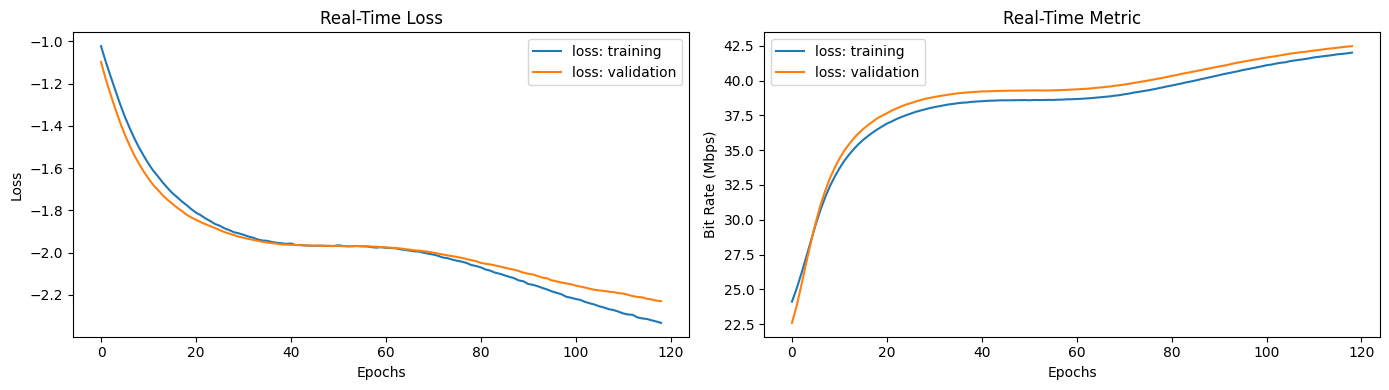

training step::   0%|          | 0/74 [00:00<?, ?batch/s]

validation step::   0%|          | 0/25 [00:00<?, ?batch/s]

In [42]:
%%script false --no-raise-error


BATCH_SIZE: int = 1024
MAX_EPOCH : int = 120
LR: float  = 1e-4

# under ideal conditions, the sisa ideal shannon rate is around 4.
REQ: float      = 8.

learning_config = {
    'loss': 'pure-min-rate',
    'max-epoch': MAX_EPOCH,
    'batch-size': BATCH_SIZE,
    'learning-rate': LR,
    'desired-norm-rate' : REQ,
    'train-valid-split' : f"{TRAIN_SAMPLE}-{VALID_SAMPLE}"
}

# training config
HS: int    = 1024
HL: int    = 6
DP: float  = 0.15
KEEP_BANDS: bool = True
WEIGHTED_GAIN: bool = True

model_config = {
    'hidden-dim': HS,
    'hidden-layers': HL,
    'keep-bands': KEEP_BANDS,
    'weighted-gain': WEIGHTED_GAIN,
}

name  = "p1-alloc-dnn-03-00-base"
training_config = {}
training_config.update(model_config)
training_config.update(learning_config)

try: wandb.finish(quiet = True)
except: pass
run = setup_wandb(name, 'rate-confirming', training_config, id = None)
print("run config:", run.config)

model = RateConfirmAllocModel(20, 4, HS, HL, DP, KEEP_BANDS, WEIGHTED_GAIN).to(device)
optimizer = optim.Adam(model.parameters(), LR, weight_decay=1e-5)
scheduler = lrs.CosineAnnealingLR(optimizer, T_max=50, eta_min=1e-6)
temp_scheduler = TemperatureScheduler(1.0, 0.98)

train_loss, valid_loss, train_rate, valid_rate = [], [], [], []
for epoch in trange(MAX_EPOCH, desc = "training epoch", unit = "epoch"):
    real_time_plot(train_loss, valid_loss, train_rate, valid_rate)

    # training step
    model.train()
    training_loss = 0.
    train_binary_loss = 0.

    temp = 1.0 # temp_scheduler.step()
    training_metrics = defaultdict(lambda : 0)
    for sample in tqdm(train_loader, desc = 'training step:', unit = 'batch', total = len(train_loader), leave=False):
        optimizer.zero_grad()

        sample     = sample.to(device)
        alloc_prob = model(sample, temp)
        loss       = loss_pure_rate(config, sample, alloc_prob, 'min').mean()
        # loss       = loss_fullfield_req(config, sample, alloc_prob, REQ).mean()
        training_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        train_binary_loss += binarization_error(alloc_prob).item()
        training_metrics = update_metrics(training_metrics, alloc_prob, sample, config, REQ)

    scheduler.step()
    training_loss = training_loss / len(train_loader)
    train_binary_loss = train_binary_loss / len(train_loader)
    training_metrics = { 'train-' + key: val / len(train_loader) for key, val in training_metrics.items()}

    model.eval()
    validation_loss = 0.
    valid_binary_loss = 0.
    validation_metrics = defaultdict(lambda : 0.)
    for sample in tqdm(valid_loader, desc = 'validation step:', unit = 'batch', total = len(valid_loader), leave = False):
        sample     = sample.to(device)
        alloc_prob = model(sample, temp)
        loss       = loss_pure_rate(config, sample, alloc_prob, 'min').mean()
        # loss       = loss_fullfield_req(config, sample, alloc_prob, REQ).mean()
        validation_loss += loss.item()

        valid_binary_loss += binarization_error(alloc_prob).item()
        validation_metrics = update_metrics(validation_metrics, alloc_prob, sample, config, REQ)

    validation_loss = validation_loss / len(valid_loader)
    valid_binary_loss = valid_binary_loss / len(valid_loader)

    validation_metrics = { 'valid-' + key: val / len(valid_loader) for key, val in validation_metrics.items()}

    logged_values = {
        'train-loss': training_loss, 'valid-loss': validation_loss, 'temperature': temp,
        'train-binary-loss': train_binary_loss, 'valid-binary-loss': valid_binary_loss
    }

    logged_values.update(training_metrics)
    logged_values.update(validation_metrics)

    train_loss.append(training_loss)
    valid_loss.append(validation_loss)
    train_rate.append(training_metrics['train-bit-rate'])
    valid_rate.append(validation_metrics['valid-bit-rate'])
    wandb.log(logged_values)

wandb.finish()
# save model
torch.save(model.state_dict(), os.path.join(MODELS_PATH, "dnn-min-003.pt") )
allc_tensor = get_test_results(model, tests_loader)
print(tests_sisa.shape, tests_sisa.shape, tests_sisa.shape)
print(update_metrics(defaultdict(lambda : 0), tests_sisa , tests_data, config, 6))
print(update_metrics(defaultdict(lambda : 0), allc_tensor, tests_data, config, 6))


 ### Using CNN Architecture

 THe previos DNN fails to consider possible relationships between subbands and the other subnetworks. We can leverage CNN architecture to do that.

In [46]:
import torch.nn as nn

def create_cnn_block( in_channels: int, out_channels: int,
                      kernel_size: int, pad_size: int = 0, stride_size: int = 1,
                      dropout: float | None = None, norm: bool = True
                    ) -> nn.Sequential:

    layers = [nn.Conv2d(in_channels, out_channels, kernel_size, stride_size, pad_size)]

    if norm:
        layers.append(nn.BatchNorm2d(out_channels))

    layers.append(nn.ReLU())

    if dropout is not None:
        layers.append(nn.Dropout(dropout))

    return nn.Sequential(*layers)


def calculate_flatten_size(input_size: tuple[int, int, int, int], cnn_layers: list[dict[str, int]]) -> tuple[tuple[int, int, int, int], int]:

    B, C, H, W = input_size  # Unpack initial dimensions

    for layer in cnn_layers:
        if layer["type"] == "conv":
            # Apply convolution formula
            H = (H + 2 * layer["padding"] - layer["kernel_size"]) // layer["stride"] + 1
            W = (W + 2 * layer["padding"] - layer["kernel_size"]) // layer["stride"] + 1
            C = layer["out_channels"]  # Update channel count

        elif layer["type"] == "pool":
            # Apply pooling formula (assuming stride = pool_size for simplicity)
            H //= layer["pool_size"]
            W //= layer["pool_size"]

        elif layer["type"] == "flatten":
            # Stop tracking spatial dimensions, return final shape
            return (B, C, H, W), C * H * W

    return (B, C, H, W), C * H * W

# Example Usage
input_size = (B := 1, C := 3, H := 32, W := 32)  # Example input: (Batch=1, Channels=3, 32x32 image)


# First Step: Subband allocation problem
class RateConfirmAllocCNNModel(nn.Module):
    def __init__(self, n_subnetworks: int, n_bands: int,
                 dropout: float | None = 0.01,
                 use_weighted: bool = False):
        super().__init__()

        # initialize state
        self.n = n_subnetworks
        self.k = n_bands

        # preprocessing options
        self.use_weighted   = use_weighted

        # DNN architecture
        self.output_size = self.n * self.k

        last_layer = -2 if dropout is None else -3
        layers = [nn.BatchNorm2d(n_bands)] # with batch norm at start


        # add CNN blocks
        layers.append(create_cnn_block(n_bands, 16,  3, 1, 1, dropout, True))
        layers.append(create_cnn_block(16, 64,  3, 0, 1, dropout, True))
        layers.append(nn.AvgPool2d(2))
        layers.append(create_cnn_block(64, 256, 3, 0, 1, dropout, True))
        layers.append(nn.AvgPool2d(2))
        layers.append(nn.Flatten())

        self.cnn_layer_info = [
            {"type": "conv", "out_channels": 16, "kernel_size": 3, "padding": 1, "stride": 1},
            {"type": "conv", "out_channels": 64, "kernel_size": 3, "padding": 0, "stride": 1},
            {"type": "pool", "pool_size": 2},  # AvgPool2d(2)
            {"type": "conv", "out_channels": 256, "kernel_size": 3, "padding": 0, "stride": 1},
            {"type": "pool", "pool_size": 2},  # AvgPool2d(2)
            {"type": "flatten"},
        ]
        flatten_size = calculate_flatten_size((1, n_bands, n_subnetworks, n_subnetworks), self.cnn_layer_info)[1]
        # add FNN blocks

        dims = [flatten_size] + [1024, 512] + [self.output_size]
        for i in range(1, len(dims)):
            # linear layers with HE initialization
            layers.append(nn.Linear(dims[i - 1], dims[i]))
            torch.nn.init.kaiming_normal_(layers[-1].weight, nonlinearity='relu')
            layers.append(nn.ReLU())

            # apply dropout. We have a lot of parameters, it is required
            layers.append(nn.BatchNorm1d(dims[i]))
            layers.append(nn.Dropout(dropout))

        layers = layers[:-3]
        self.model = nn.Sequential(*layers)

    def preprocess(self, channel_gain: np.ndarray | torch.Tensor ) -> torch.Tensor:
        channel_gain = torch.tensor(channel_gain, requires_grad=False).float()
        device       = channel_gain.device
        if self.use_weighted:
            # normalize the interference matrix
            Hd = torch.diagonal(channel_gain, dim1 = -2, dim2 = -1).unsqueeze(-1)

            zero = torch.zeros_like(channel_gain).to(channel_gain.device)
            channel_gain = torch.where(Hd > 0, channel_gain / Hd, zero)

            # remove self-interference
            B, K, N, _ = channel_gain.shape
            self_signal = torch.eye(N, device = device).expand(B, K, -1, -1)
            channel_gain = channel_gain * (1 - self_signal)

        # transform to dbm scale to restrict value range
        channel_gain = 10 * torch.log10(channel_gain + 1e-9) # transform to Dbm

        # normalize to values.
        # cavg = channel_gain.mean(dim = 1, keepdim = True)
        # cstd = channel_gain.std( dim = 1, keepdim = True)
        # channel_gain = (channel_gain - cavg) / cstd
        return channel_gain

    def forward(self, channel_gain: torch.Tensor, t: float = 1.0 ) -> torch.Tensor:
        # preprocess to obtain a NxN channel gain
        channel_gain = self.preprocess(channel_gain)
        # apply model
        channel_network = self.model(channel_gain)
        # determine best allocation
        channel_network = channel_network.reshape(-1, self.k, self.n)
        # derive probabilities
        return F.softmax(channel_network / t, dim = 1)

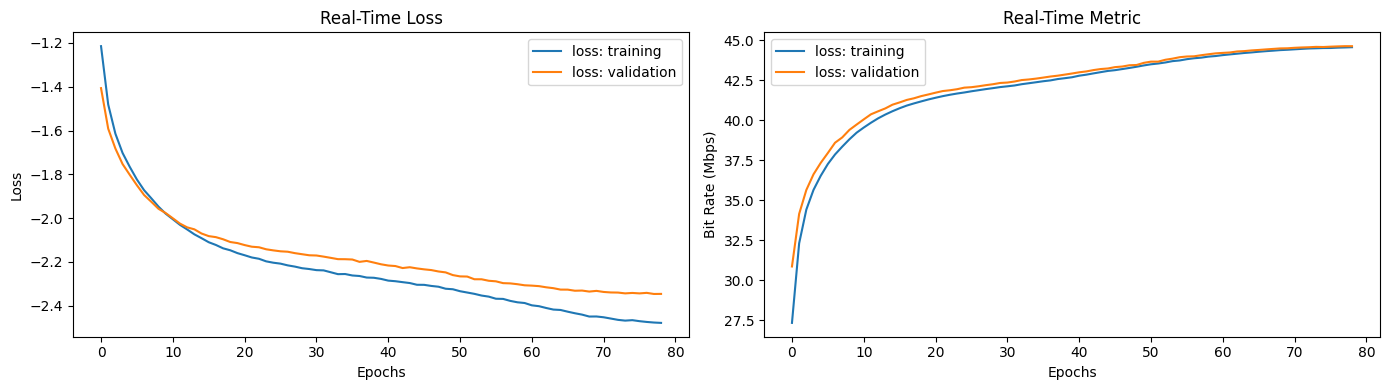

training step::   0%|          | 0/74 [00:00<?, ?batch/s]

validation step::   0%|          | 0/25 [00:00<?, ?batch/s]

torch.Size([30000, 20]) torch.Size([30000, 20]) torch.Size([30000, 20])
defaultdict(<function <lambda> at 0x7d1024253740>, {'bit-rate': 44.07538, 'jain-fairness': 0.9332454204559326, 'spectral-efficency': 4.407537937164307, 'proportional-loss': 0.9428113102912903, 'over-requirement': 0.08050667494535446})
defaultdict(<function <lambda> at 0x7d10246b5760>, {'bit-rate': 44.665776, 'jain-fairness': 0.9368879199028015, 'spectral-efficency': 4.466578006744385, 'proportional-loss': 0.8821370601654053, 'over-requirement': 0.08778999745845795})


In [47]:
BATCH_SIZE: int = 1024
MAX_EPOCH : int = 80
LR: float  = 3e-4

# under ideal conditions, the sisa ideal shannon rate is around 4.
REQ: float      = 8.

learning_config = {
    'loss': 'pure-min-rate',
    'max-epoch': MAX_EPOCH,
    'batch-size': BATCH_SIZE,
    'learning-rate': LR,
    'desired-norm-rate' : REQ,
    'train-valid-split' : f"{TRAIN_SAMPLE}-{VALID_SAMPLE}"
}

# training config
HS: int    = 1024
HL: int    = 6
DP: float  = 0.1
KEEP_BANDS: bool = True
WEIGHTED_GAIN: bool = True

model_config = {
    'dropout': DP,
    'weighted-gain': WEIGHTED_GAIN,
}

name  = "p1-alloc-cnn-00-01-base"
training_config = {}
training_config.update(model_config)
training_config.update(learning_config)

try: wandb.finish(quiet = True)
except: pass
run = setup_wandb(name, 'cnn-rate-confirming', training_config, id = None)
print("run config:", run.config)

model = RateConfirmAllocCNNModel(20, 4, DP, WEIGHTED_GAIN).to(device)
optimizer = optim.Adam(model.parameters(), LR, weight_decay=1e-5)
scheduler = lrs.CosineAnnealingLR(optimizer, T_max=25, eta_min=1e-4)
temp_scheduler = TemperatureScheduler(1.0, 0.98)
train_loss, valid_loss, train_rate, valid_rate = [], [], [], []
for epoch in trange(MAX_EPOCH, desc = "training epoch", unit = "epoch"):
    real_time_plot(train_loss, valid_loss, train_rate, valid_rate)

    # training step
    model.train()
    training_loss = 0.
    train_binary_loss = 0.

    temp = 1.0 # temp_scheduler.step()
    training_metrics = defaultdict(lambda : 0)
    for sample in tqdm(train_loader, desc = 'training step:', unit = 'batch', total = len(train_loader), leave=False):
        optimizer.zero_grad()

        sample     = sample.to(device)
        alloc_prob = model(sample, temp)
        loss       = loss_pure_rate(config, sample, alloc_prob, 'min').mean()
        # loss       = loss_fullfield_req(config, sample, alloc_prob, REQ).mean()
        training_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        train_binary_loss += binarization_error(alloc_prob).item()
        training_metrics = update_metrics(training_metrics, alloc_prob, sample, config, REQ)

    scheduler.step()
    training_loss = training_loss / len(train_loader)
    train_binary_loss = train_binary_loss / len(train_loader)
    training_metrics = { 'train-' + key: val / len(train_loader) for key, val in training_metrics.items()}

    model.eval()
    validation_loss = 0.
    valid_binary_loss = 0.
    validation_metrics = defaultdict(lambda : 0.)
    for sample in tqdm(valid_loader, desc = 'validation step:', unit = 'batch', total = len(valid_loader), leave = False):
        sample     = sample.to(device)
        alloc_prob = model(sample, temp)
        loss       = loss_pure_rate(config, sample, alloc_prob, 'min').mean()
        # loss       = loss_fullfield_req(config, sample, alloc_prob, REQ).mean()
        validation_loss += loss.item()

        valid_binary_loss += binarization_error(alloc_prob).item()
        validation_metrics = update_metrics(validation_metrics, alloc_prob, sample, config, REQ)

    validation_loss = validation_loss / len(valid_loader)
    valid_binary_loss = valid_binary_loss / len(valid_loader)

    validation_metrics = { 'valid-' + key: val / len(valid_loader) for key, val in validation_metrics.items()}

    logged_values = {
        'train-loss': training_loss, 'valid-loss': validation_loss, 'temperature': temp,
        'train-binary-loss': train_binary_loss, 'valid-binary-loss': valid_binary_loss
    }

    logged_values.update(training_metrics)
    logged_values.update(validation_metrics)

    train_loss.append(training_loss)
    valid_loss.append(validation_loss)
    train_rate.append(training_metrics['train-bit-rate'])
    valid_rate.append(validation_metrics['valid-bit-rate'])
    wandb.log(logged_values)

wandb.finish()
torch.save(model.state_dict(), os.path.join(MODELS_PATH, "cnn-min-00-01.pt") )
allc_tensor = get_test_results(model, tests_loader)
print(tests_sisa.shape, tests_sisa.shape, tests_sisa.shape)
print(update_metrics(defaultdict(lambda : 0), tests_sisa , tests_data, config, 6))
print(update_metrics(defaultdict(lambda : 0), allc_tensor, tests_data, config, 6))



In [48]:
def calculate_model_size(model: nn.Module):
  param_size = 0
  for param in model.parameters():
      param_size += param.nelement() * param.element_size()
  buffer_size = 0
  for buffer in model.buffers():
      buffer_size += buffer.nelement() * buffer.element_size()

  size_all_mb = (param_size + buffer_size) / 1024**2
  return size_all_mb


###  Graph Based Approach

In [ ]:
def create_large_graph(channel_gain: torch.Tensor) -> Data:
    B, K, N, _ = channel_gain.shape
    device = channel_gain.device
    total_nodes = B * N  # All nodes from all batches

    # Compute node features
    interference = channel_gain.mean(dim=1)  # Average over K
    node_features = interference.mean(dim=1)  # Average over N

    print("creatiing edges", node_features.shape)

    # Mask diagonal elements (self-interference)
    mask = torch.eye(N, device=device).bool()
    interference.masked_fill_(mask[None, :, :], float('-inf'))

    # Find top K-1 strongest interfering nodes per batch
    neighbors = torch.topk(interference, k=K-1, dim=-1).indices

    # Generate global node indices
    batch_offset = torch.arange(B, device=device)[:, None] * N  # Offset for batch indexing
    global_src_nodes = (torch.arange(N, device=device).repeat(B, K-1).view(B, N, K-1) + batch_offset[:, None, None]).flatten()
    global_neighbors = (neighbors + batch_offset[:, None, None]).flatten()

    print("creatiing edges")

    # Construct edge index
    edge_index = torch.stack([global_src_nodes, global_neighbors], dim=0)
    valid_edges = edge_index[0] != edge_index[1]  # Remove self-loops
    edge_index = edge_index[:, valid_edges]

    # Node features for all nodes
    node_features = node_features.view(-1, 1)  # Reshape to (B*N, 1)

    # Create training mask (70% of batches, ensuring full batches are selected)
    train_mask = torch.zeros(total_nodes, dtype=torch.bool, device=device)
    num_train_batches = int(0.7 * B)
    selected_batches = torch.randperm(B, device=device)[:num_train_batches]
    batch_mask = torch.zeros(B, dtype=torch.bool, device=device)
    batch_mask[selected_batches] = True
    train_mask = batch_mask.repeat_interleave(N)

    return Data(x=node_features, edge_index=edge_index, train_mask=train_mask)

train_data, _ = random_split( whole_data, [TRAIN_SAMPLE, VALID_SAMPLE] )
graphs = create_large_graph(train_data.dataset.tensors[0])
print(graphs.x.shape)


In [ ]:
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x


In [ ]:
from torch_geometric.nn import GCNConv, GATConv, global_mean_pool
class RateConfirmGNNModel(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, num_layers=2):
        super().__init__()

# GCN layers
        self.conv_layers = nn.ModuleList([
            GCNConv(in_dim, hidden_dim) if i == 0 else GCNConv(hidden_dim, hidden_dim)
            for i in range(num_layers)
        ])

        # GRU layer
        self.gru = nn.GRU(input_size=hidden_dim, hidden_size=hidden_dim, batch_first=True)

        # Output layer for classification
        self.fc_out = nn.Linear(hidden_dim, out_dim)

    def forward(self, data):
        # Ensure that the data is a batch
        x, edge_index, batch = data.x, data.edge_index, data.batch

        # GCN Layers
        for conv in self.conv_layers:
            x = F.relu(conv(x, edge_index))

        # GRU layer (processing sequential dependencies)
        # GRU expects input shape: (batch_size, seq_len, input_size)
        # Here, seq_len = num_nodes, input_size = hidden_dim after the GCN layer
        x = x.view(-1, x.size(1), x.size(2))  # (B * N, hidden_dim) -> (B, N, hidden_dim)
        x, _ = self.gru(x)  # x: (B, N, hidden_dim)

        # Readout operation: take the node features and pass through the output layer
        x = x.mean(dim=1)  # Pooling: global mean of node features

        # Final classification layer
        x = self.fc_out(x)  # Output shape: (B, out_dim)

        return x

# Example usage:
model = RateConfirmGNNModel(in_dim=1, hidden_dim=64, out_dim=4)  # K is the number of subbands
graphs = create_graphs(next(iter(train_data))[0])

model.eval()
model(graphs[0])


In [ ]:
BATCH_SIZE: int = 1024
MAX_EPOCH : int = 80
LR: float  = 3e-4

# under ideal conditions, the sisa ideal shannon rate is around 4.
REQ: float      = 8.

learning_config = {
    'loss': 'pure-min-rate',
    'max-epoch': MAX_EPOCH,
    'batch-size': BATCH_SIZE,
    'learning-rate': LR,
    'desired-norm-rate' : REQ,
    'train-valid-split' : f"{TRAIN_SAMPLE}-{VALID_SAMPLE}"
}

# training config
HS: int    = 1024
DP: float  = 0.1

model_config = {
    'dropout': DP,
    'hidden-dim': HS,
}

name  = "p1-alloc-gnn-00-01-base"
training_config = {}
training_config.update(model_config)
training_config.update(learning_config)

try: wandb.finish(quiet = True)
except: pass
run = setup_wandb(name, 'gnn-rate-confirming', training_config, id = None)
print("run config:", run.config)

model = SubbandAllocationGNN(4, HS, 20, 4).to(device)
optimizer = optim.Adam(model.parameters(), LR, weight_decay=1e-5)
scheduler = lrs.CosineAnnealingLR(optimizer, T_max=25, eta_min=1e-4)
temp_scheduler = TemperatureScheduler(1.0, 0.98)

train_loss, valid_loss, train_rate, valid_rate = [], [], [], []
for epoch in trange(MAX_EPOCH, desc = "training epoch", unit = "epoch"):
    real_time_plot(train_loss, valid_loss, train_rate, valid_rate)

    # training step
    model.train()
    training_loss = 0.
    train_binary_loss = 0.

    temp = 1.0 # temp_scheduler.step()
    training_metrics = defaultdict(lambda : 0)
    for sample in tqdm(train_data, desc = 'training step:', unit = 'batch', total = len(train_data), leave=False):
        optimizer.zero_grad()

        sample     = sample[0].to(device)
        alloc_prob = model(sample)
        loss       = loss_pure_rate(config, sample, alloc_prob, 'min').mean()
        # loss       = loss_fullfield_req(config, sample, alloc_prob, REQ).mean()
        training_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        train_binary_loss += binarization_error(alloc_prob).item()
        training_metrics = update_metrics(training_metrics, alloc_prob, sample, config, REQ)

    scheduler.step()
    training_loss = training_loss / len(train_data)
    train_binary_loss = train_binary_loss / len(train_data)
    training_metrics = { 'train-' + key: val / len(train_data) for key, val in training_metrics.items()}

    model.eval()
    validation_loss = 0.
    valid_binary_loss = 0.
    validation_metrics = defaultdict(lambda : 0.)
    for sample in tqdm(valid_data, desc = 'validation step:', unit = 'batch', total = len(valid_data), leave = False):
        sample     = sample[0].to(device)
        alloc_prob = model(sample)
        loss       = loss_pure_rate(config, sample, alloc_prob, 'min').mean()
        # loss       = loss_fullfield_req(config, sample, alloc_prob, REQ).mean()
        validation_loss += loss.item()

        valid_binary_loss += binarization_error(alloc_prob).item()
        validation_metrics = update_metrics(validation_metrics, alloc_prob, sample, config, REQ)

    validation_loss = validation_loss / len(valid_data)
    valid_binary_loss = valid_binary_loss / len(valid_data)

    validation_metrics = { 'valid-' + key: val / len(valid_data) for key, val in validation_metrics.items()}

    logged_values = {
        'train-loss': training_loss, 'valid-loss': validation_loss, 'temperature': temp,
        'train-binary-loss': train_binary_loss, 'valid-binary-loss': valid_binary_loss,
        'learning-rate': scheduler.get_lr()[0]
    }

    logged_values.update(training_metrics)
    logged_values.update(validation_metrics)

    train_loss.append(training_loss)
    valid_loss.append(validation_loss)
    train_rate.append(training_metrics['train-bit-rate'])
    valid_rate.append(validation_metrics['valid-bit-rate'])
    wandb.log(logged_values)

wandb.finish()

sisa_tensor = torch.tensor(sisa_alloc[-30_000:]).type(torch.int64).to(device)
data_tensor = torch.tensor(cmg[-30_000:]).to(device)
allc_tensor = model(data_tensor).to(device)

print(sisa_tensor.shape, data_tensor.shape, allc_tensor.shape)
print(update_metrics(defaultdict(lambda : 0), sisa_tensor, data_tensor, config, 6))
print(update_metrics(defaultdict(lambda : 0), allc_tensor, data_tensor, config, 6))
